# **CHAPTER 5. All New Functional Annotation**

Import all the needed for analysis modules

In [1]:
import pandas as pd
from kegganog import boxplot as keggabox
from kegganog import grouped_heatmap_multi
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Make a directory to store the data

In [ ]:
! mkdir data/

Download all the `uncharacterized proteins` for `Pseudogymnoascus destructans` - there are 16.425 of them in NCBI RefSeq

In [ ]:
! esearch -db nucleotide \
    -query '"Pseudogymnoascus destructans" AND Fungi AND "uncharacterized" AND srcdb_refseq[PROP]' \
    | efetch -format fasta > data/uncharacterized.fasta

Download all the `characterized proteins` for `Pseudogymnoascus destructans` - there are 3.909 of them in NCBI RefSeq

In [ ]:
! esearch -db nucleotide \
    -query '"Pseudogymnoascus destructans" AND Fungi NOT "uncharacterized" AND srcdb_refseq[PROP]' \
    | efetch -format fasta > data/characterized.fasta

Combine all the proteins for `Pseudogymnoascus destructans` in one complete `.fasta` file

In [ ]:
! cat data/*.fasta > data/complete.fasta

Run `eggNOG-mapper` on all 3 `.fasta` files

In [ ]:
! snakemake -s emapp_pipeline --cores all

The function below will delete any duplicates from `eggNOG-mapper` annotations

In [2]:
def clean_eggnog_annotations(input_file, output_file):
    # Read file while skipping first 4 rows
    df = pd.read_csv(input_file, sep="\t", skiprows=4)

    # Drop unwanted columns
    columns_to_drop = ["#query", "seed_ortholog", "evalue", "score"]
    df = df.drop(columns=columns_to_drop, errors="ignore")  # Ignore if columns are missing

    # Remove duplicate rows
    df = df.drop_duplicates()

    # Save the cleaned data
    df.to_csv(output_file, sep="\t", index=False)

    print(f"Cleaned file saved as: {output_file}")

The function below will count `COG_category` entries

In [3]:
def count_cog_categories(input_file, output_file):
    # Load the cleaned annotation file
    df = pd.read_csv(input_file, sep="\t")

    # Check if 'COG_category' exists
    if "COG_category" not in df.columns:
        print("Error: 'COG_category' column not found in the file!")
        return

    # Count unique COG categories
    cog_counts = df["COG_category"].value_counts().reset_index()
    cog_counts.columns = ["COG_category", "Count"]  # Rename columns

    # Save as TSV
    cog_counts.to_csv(output_file, sep="\t", index=False, header=False)

    print(f"COG category counts saved as: {output_file}")

The function below will treat multi-letter `COG_category` as the single-letter `COG_category` based on the 1st letter (e.g. KTN -> K)

In [4]:
def process_cog_category_counts(input_file, output_file):
    # Read the input file into a DataFrame
    df = pd.read_csv(input_file, sep='\t', header=None, names=["Category", "Count"])

    # Remove the row with "-"
    df = df[df['Category'] != '-']
    
    # Iterate over the categories and merge counts for multi-letter entries
    # Extract the first letter of multi-letter entries and add the counts
    for index, row in df.iterrows():
        category = row['Category']
        if len(category) > 1:  # Check if it's a multi-letter category
            first_letter = category[0]
            df.loc[df['Category'] == first_letter, 'Count'] += row['Count']
            df = df.drop(index)  # Drop the multi-letter entry

    # Save the modified DataFrame to an output file
    df.to_csv(output_file, sep='\t', index=False, header=False)

    print(f"Processed COG category counts saved as: {output_file}")

Now run all these 3 functions on 3 profiles: `complete`, `characterized` & `uncharacterized`

In [5]:
categories = ["complete", "characterized", "uncharacterized"]

for category in categories:
    raw_file = f"eggNOG/{category}/{category}.emapper.annotations"
    clean_file = f"eggNOG/{category}/clean_{category}.emapper.annotations"
    count_file = f"eggNOG/{category}/{category}_cog_category_counts.tsv"
    clean_count_file = f"eggNOG/{category}/{category}_cog_category_counts_clean.tsv"

    clean_eggnog_annotations(raw_file, clean_file)
    count_cog_categories(clean_file, count_file)
    process_cog_category_counts(count_file, clean_count_file)

Cleaned file saved as: eggNOG/complete/clean_complete.emapper.annotations
COG category counts saved as: eggNOG/complete/complete_cog_category_counts.tsv
Processed COG category counts saved as: eggNOG/complete/complete_cog_category_counts_clean.tsv
Cleaned file saved as: eggNOG/characterized/clean_characterized.emapper.annotations
COG category counts saved as: eggNOG/characterized/characterized_cog_category_counts.tsv
Processed COG category counts saved as: eggNOG/characterized/characterized_cog_category_counts_clean.tsv
Cleaned file saved as: eggNOG/uncharacterized/clean_uncharacterized.emapper.annotations
COG category counts saved as: eggNOG/uncharacterized/uncharacterized_cog_category_counts.tsv
Processed COG category counts saved as: eggNOG/uncharacterized/uncharacterized_cog_category_counts_clean.tsv


Now, proceed to `02_COG_visualization.R` to visualize `COG_category` counts!

## **KEGGaNOG**

Just for fun let's run `KEGGaNOG` on these `eggNOG-mapper` annotations! Althought `KEGGaNOG` uses `KEGG-Decoder` which decodes `KEGG_ko` terms based on `KEGG`'s reference module database (which is bacterial oritented) it will be interesting to run it on fungal data! Just for exploratory purposes!

Run a `KEGGaNOG` to investigate the pathways of _Pseudogymnoascus destructans_

Check the version of `KEGGaNOG`

In [2]:
! KEGGaNOG -V

KEGGaNOG by Ilia V. Popov
KEGGaNOG 0.7.42


Create a directory to store all the `KEGGaNOG` data

In [1]:
! mkdir KEGGaNOG_data/

### **Part 1. Complete functional profile**

Run `KEGGaNOG` in single mode on complete profile only

In [ ]:
! KEGGaNOG -i eggNOG/complete/complete.emapper.annotations -o KEGGaNOG_data/Pd -c Greens -g -n '$\it{P. desctructans}$' -dpi 600

KEGGaNOG by Ilia V. Popov
Saving plot: 100%|████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]
Figure(2800x2000)
Creating heatmap parts: 100%|█████████████████████| 3/3 [00:06<00:00,  2.09s/it]
Heatmap saved in KEGGaNOG_data/Pd/heatmap_figure.png


In [2]:
! mkdir imgs/

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
/var/folders/kn/dm4gk8l50h9ccw7mv7pwj2dc0000gn/T/ipykernel_2575/1394151009.py:2: SyntaxWarning: invalid escape sequence '\i'
  file_path = "KEGGaNOG_data/Pd/$\it{P. desctructans}$_pathways.tsv"  # Update with your file path
/var/folders/kn/dm4gk8l50h9ccw7mv7pwj2dc0000gn/T/ipykernel_2575/1394151009.py:25: UserWarning: The palette list has more values (22) than needed (16), which may not be intended.
  sns.barplot(data=pd_df_melted, x="Score", y="Pathway", hue="Score", palette=palette, dodge=False, legend=False)


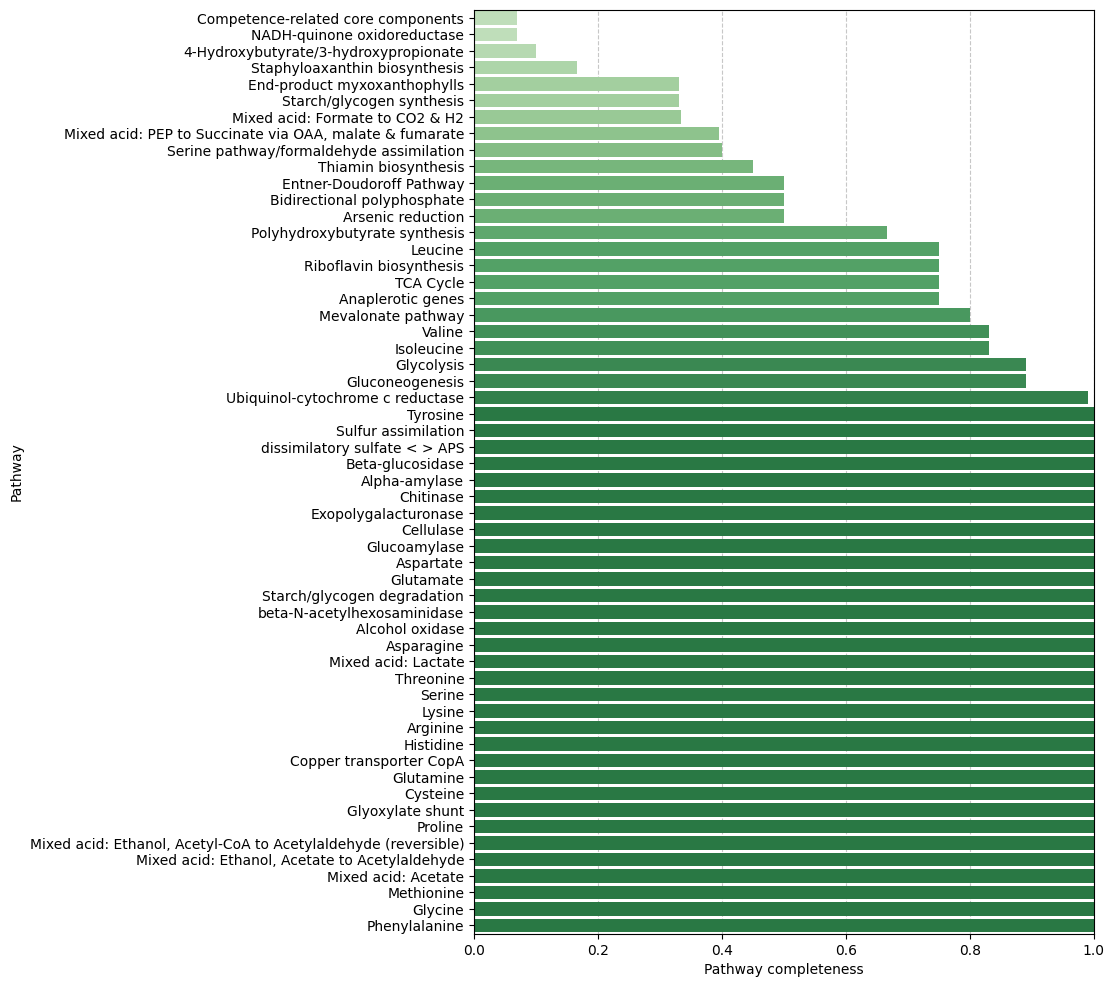

In [2]:
# Load the data
file_path = "KEGGaNOG_data/Pd/$\it{P. desctructans}$_pathways.tsv"  # Update with your file path
pd_df = pd.read_csv(file_path, sep="\t")

# Drop the "Function" column since it's not needed
pd_df_filtered = pd_df.drop(columns=["Function"])

# Keep only pathways with values greater than 0
pd_df_nonzero = pd_df_filtered.loc[:, (pd_df_filtered > 0).any(axis=0)]

# Reshape data into long format
pd_df_melted = pd_df_nonzero.melt(var_name="Pathway", value_name="Score")

# Sort by score for better visualization
pd_df_melted = pd_df_melted.sort_values(by="Score", ascending=False).reset_index(drop=True)

# Convert to sentence case if in lowercase
pd_df_melted['Pathway'] = pd_df_melted['Pathway'].apply(lambda x: x.capitalize() if x.islower() else x)

plt.figure(figsize=(8, 12))

# Generate more colors than needed, then take only the darker ones
palette = sns.color_palette("Greens", n_colors=30)[8:]  # Skip the first 5 bright colors

sns.barplot(data=pd_df_melted, x="Score", y="Pathway", hue="Score", palette=palette, dodge=False, legend=False)

plt.xlabel("Pathway completeness")
plt.ylabel("Pathway")
plt.gca().invert_yaxis()

# Add grid lines below the barplot
plt.grid(axis='x', linestyle='--', alpha=0.7, zorder=0)

# Limit the frame border to 1.0 on the x-axis
plt.xlim(0, 1.0)

# Ensure bars are drawn on top by setting zorder higher than grid
plt.gca().set_axisbelow(True)

plt.savefig("imgs/barplot.png", dpi=600, bbox_inches="tight")
plt.show()

## **Part 2. Comparison of characterized and completed profiles**

Create an input file for `KEGGaNOG`

In [2]:
! ls eggNOG/*/*.annotations > KEGGaNOG_data/KEGGaNOG_input.txt

Run `KEGGaNOG` in multi mode on all the 3 profiles!

In [6]:
! KEGGaNOG -M -i KEGGaNOG_data/KEGGaNOG_input.txt -o KEGGaNOG_data/comparison -c Greens -g -dpi 600

KEGGaNOG by Ilia V. Popov
Parsing eggNOG/characterized/characterized.emapper.annotations...
Reading characterized: 100%|██████████████████████| 1/1 [00:00<00:00, 19.01it/s]
Formatting characterized: 2it [00:00, 334.85it/s]                               
Running KEGG-Decoder on characterized...
Executing KEGG-Decoder: 100%|█████████████████████| 1/1 [00:00<00:00,  1.64it/s]
Parsing eggNOG/uncharacterized/uncharacterized.emapper.annotations...
Reading uncharacterized: 100%|████████████████████| 1/1 [00:00<00:00,  2.71it/s]
Formatting uncharacterized: 2it [00:00, 79.03it/s]                              
Running KEGG-Decoder on uncharacterized...
Executing KEGG-Decoder: 100%|█████████████████████| 1/1 [00:00<00:00,  1.39it/s]
Parsing eggNOG/complete/complete.emapper.annotations...
Reading complete: 100%|███████████████████████████| 1/1 [00:00<00:00,  2.44it/s]
Formatting complete: 2it [00:00, 74.74it/s]                                     
Running KEGG-Decoder on complete...
Executing KEGG

Reorder columns in `KEGGaNOG`'s `merged_pathways.tsv` dataframe

In [3]:
# Load your dataset
multi_df = pd.read_csv("KEGGaNOG_data/comparison/merged_pathways.tsv", sep="\t")

Check the current columns order

In [4]:
multi_df.head(5)

,Function,complete,characterized,uncharacterized
0,3-Hydroxypropionate Bicycle,0.00,0.00,0.00
1,4-Hydroxybutyrate/3-hydroxypropionate,0.10,0.10,0.10
2,Adhesion,0.00,0.00,0.00
3,Anaplerotic genes,0.75,0.50,0.75
4,Arsenic reduction,0.50,0.25,0.50


Total mess! Let's reorder it

In [5]:
multi_df = multi_df[['Function', 'characterized', 'uncharacterized', 'complete']]
multi_df.rename(columns={'characterized': 'Characterized',
                         'uncharacterized': 'Uncharacterized',
                         'complete': 'Complete'}, inplace=True)

And check how it is now

In [6]:
multi_df.head(2)

,Function,Characterized,Uncharacterized,Complete
0,3-Hydroxypropionate Bicycle,0.0,0.0,0.0
1,4-Hydroxybutyrate/3-hydroxypropionate,0.1,0.1,0.1


Seems like we characterized a lot of new pathways!

Finally, let's reorder column in multi heatmap

Create a directory to store reordered heatmap

In [18]:
! mkdir KEGGaNOG_data/comparison/reord_heatmap/

Run `KEGGaNOG` multi heatmap function on reordered df!

Creating heatmap parts: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]
/Volumes/SAMSUNG_SSD/Documents/miniconda3/conda_envs/kegganog/lib/python3.12/site-packages/kegganog/grouped_heatmap_multi.py:231: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])
Saving plot: 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


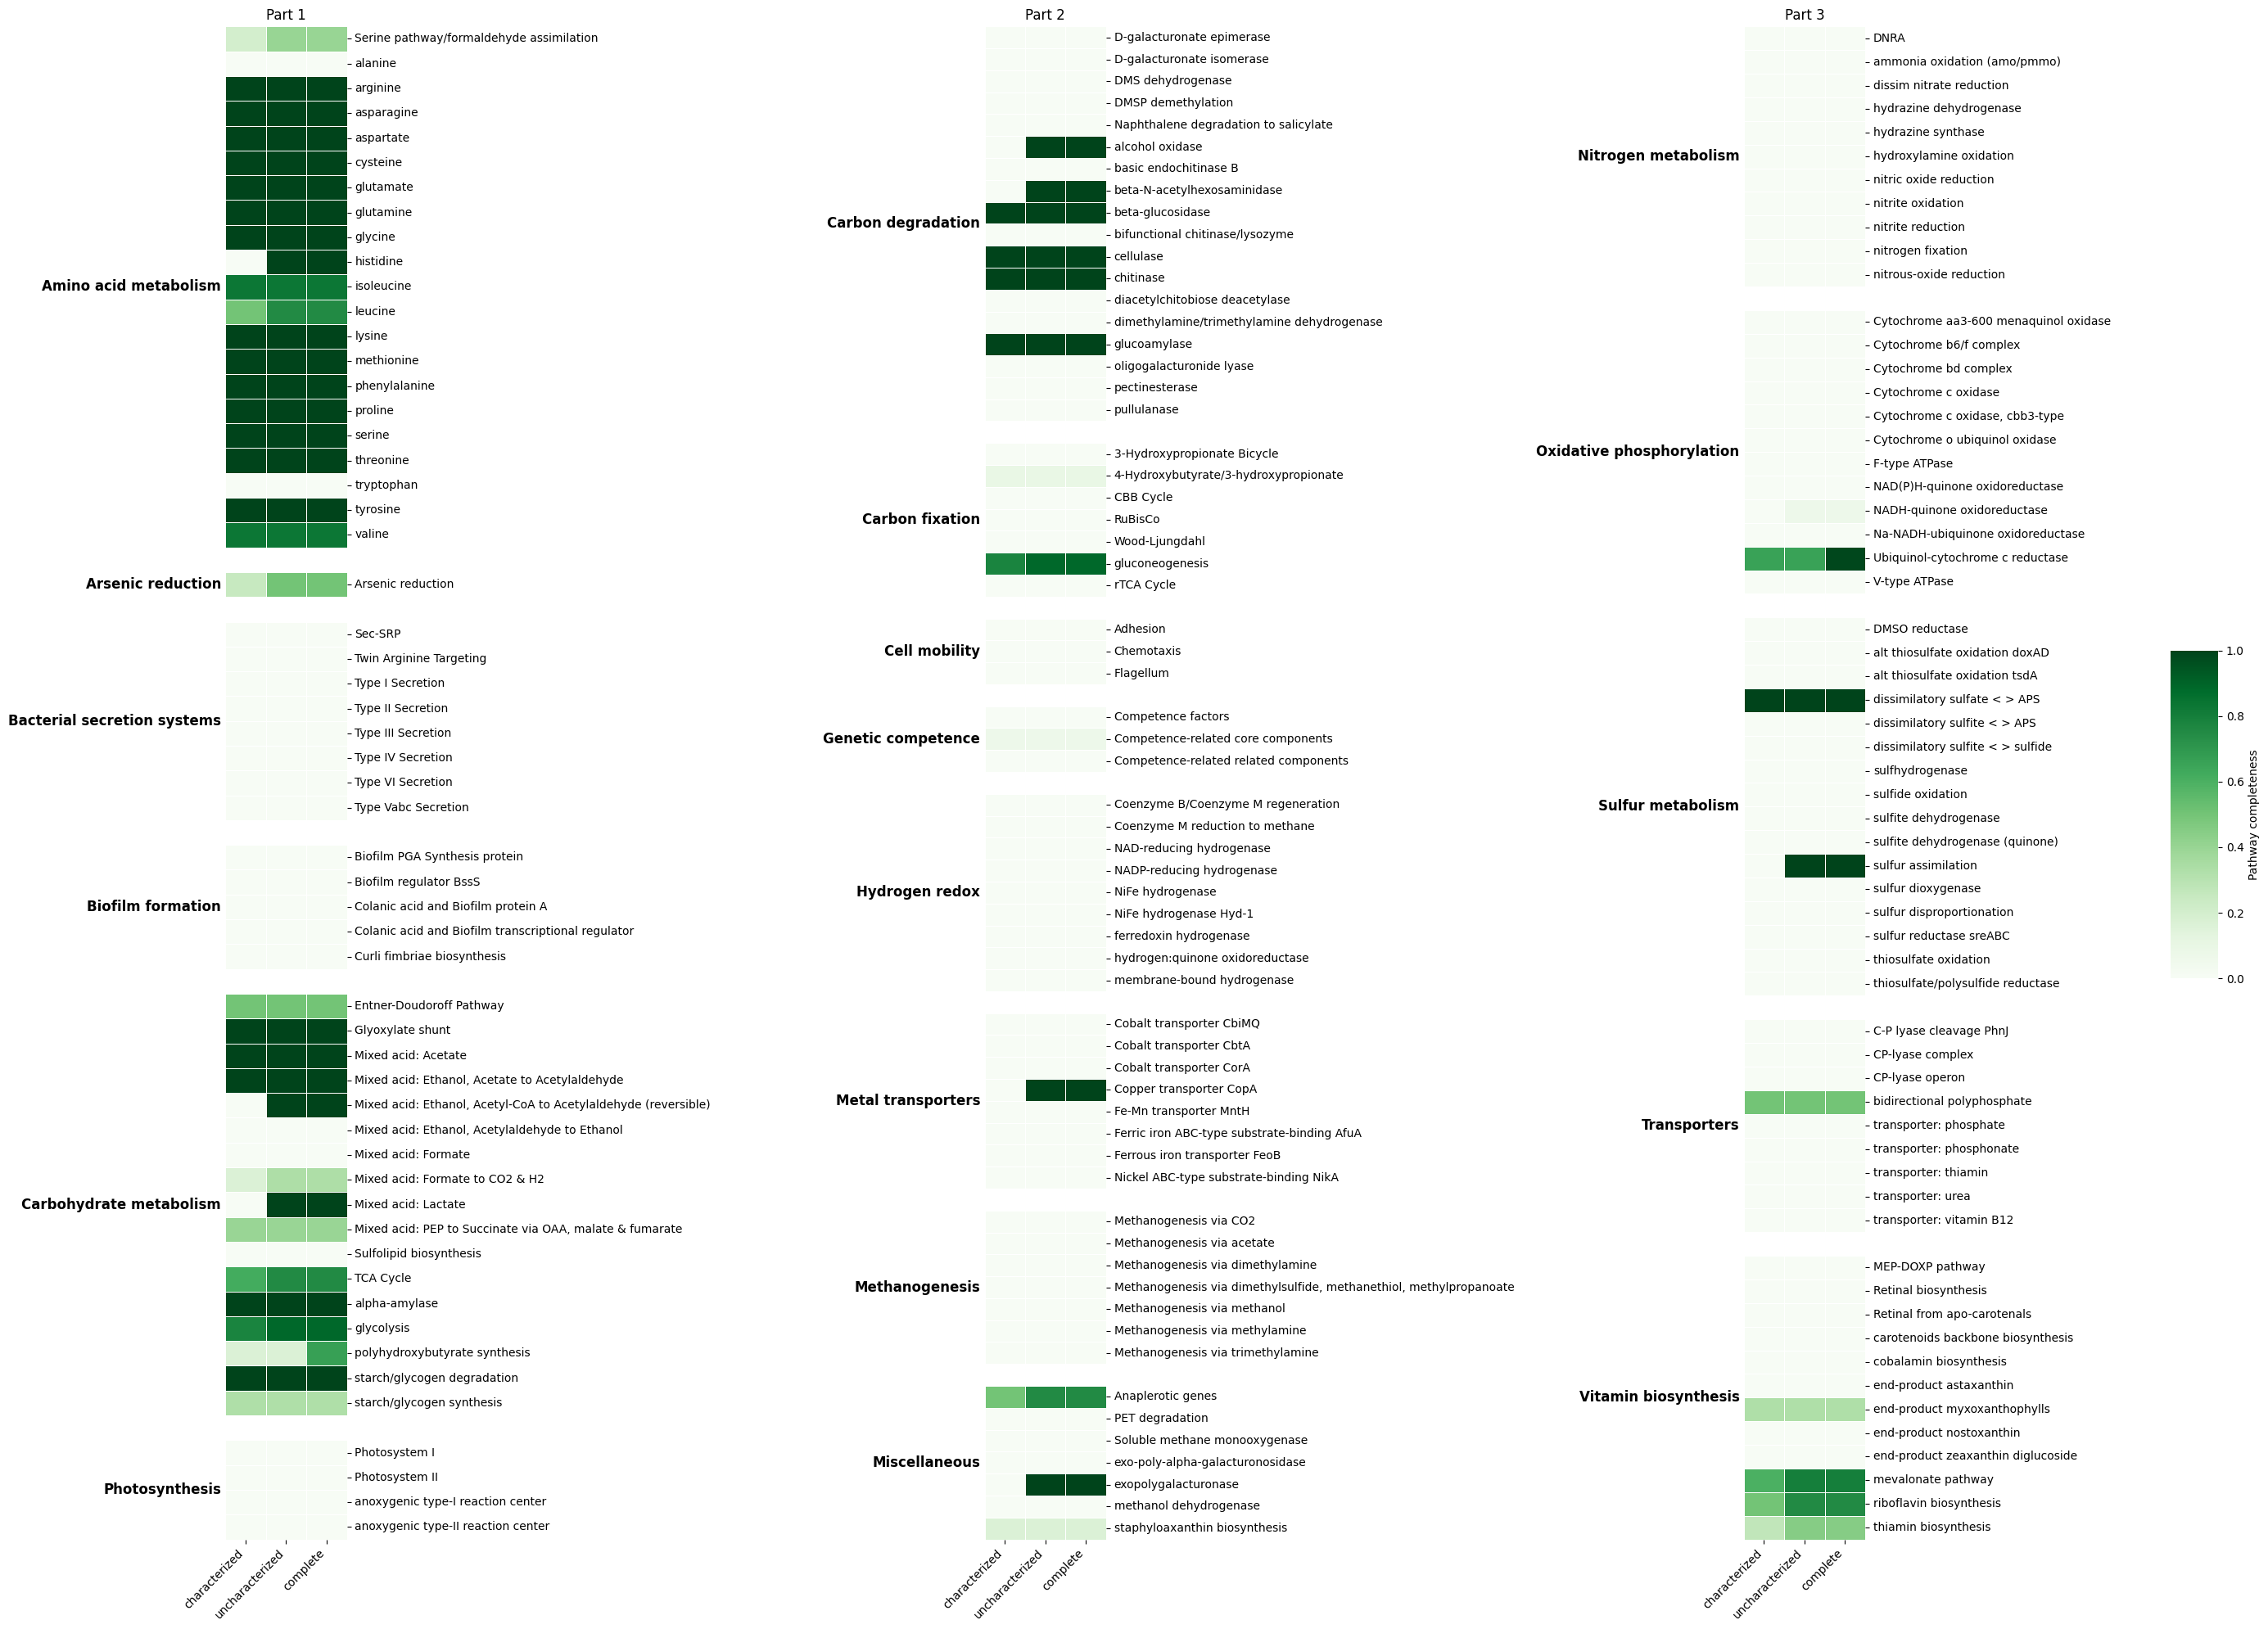

In [ ]:
grouped_heatmap_multi.generate_grouped_heatmap_multi(multi_df, "KEGGaNOG_data/comparison/reord_heatmap", 600, "Greens")

Well, that's good. But, let's create a heatmap of only "completed" pathways!

/var/folders/kn/dm4gk8l50h9ccw7mv7pwj2dc0000gn/T/ipykernel_2575/1680103396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_df_completed['Function'] = multi_df_completed['Function'].apply(lambda x: x.capitalize() if x.islower() else x)


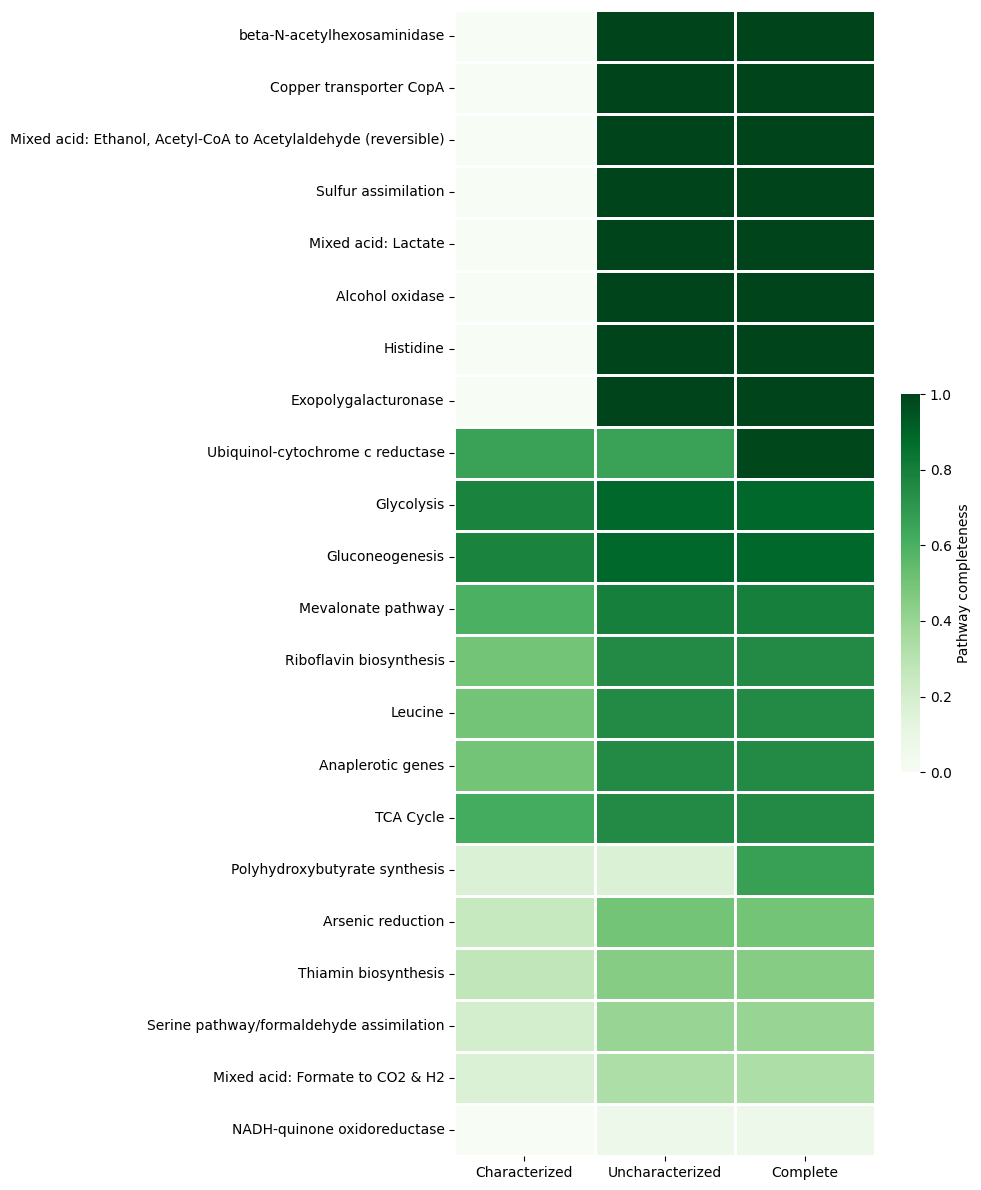

In [7]:
multi_df_completed = multi_df[multi_df["Complete"] > multi_df["Characterized"]]
multi_df_completed['Function'] = multi_df_completed['Function'].apply(lambda x: x.capitalize() if x.islower() else x)

plt.figure(figsize=(10, 12))

# Reorder the rows based on the maximum value of each row
df_sorted = multi_df_completed.set_index("Function")
df_sorted = df_sorted.loc[df_sorted.max(axis=1).sort_values(ascending=False).index]

ax = sns.heatmap(
    df_sorted,
    cmap="Greens",
    annot=False,
    linewidths=2,
    cbar=True,  # Enable colorbar
    cbar_kws={"label": "Pathway completeness", "shrink": 0.33},
)

plt.xticks(rotation=0)
plt.ylabel("")
plt.tight_layout()

plt.savefig("imgs/heatmap.png", dpi=600, bbox_inches="tight")
plt.show()

And now let's transpose this heatmap

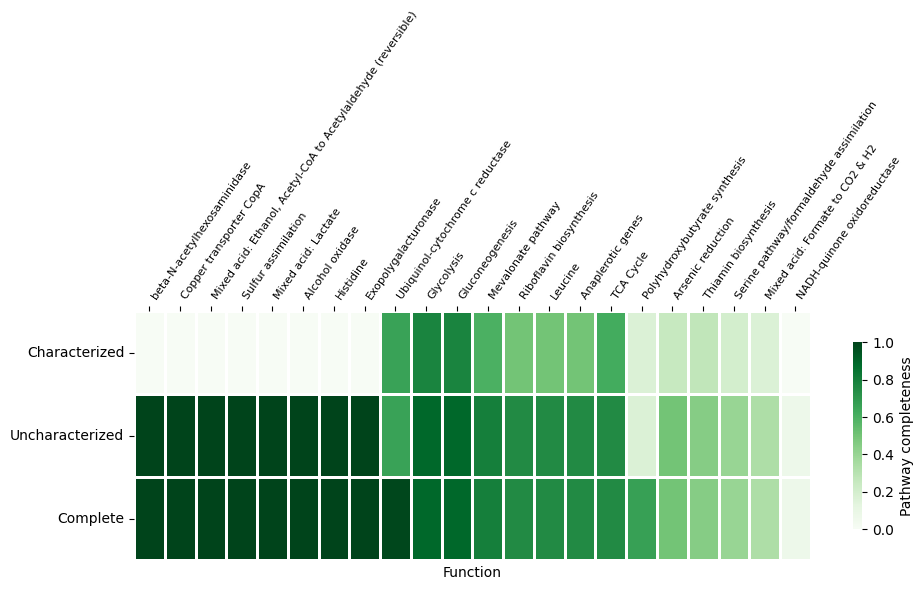

In [9]:
plt.figure(figsize=(10, 6))

ax = sns.heatmap(
    df_sorted.T,
    cmap="Greens",
    annot=False,
    linewidths=2,
    cbar=True,
    cbar_kws={"label": "Pathway completeness", "shrink": 0.75},
)

ax.xaxis.set_ticks_position('top')
plt.xlabel("Function")  # Теперь это ось X
plt.ylabel("")  # Очищаем Y
plt.xticks(rotation=55, ha='left', fontsize=8)
plt.yticks(rotation=0)  # Подписей на X теперь больше, их нужно развернуть
plt.tight_layout()

plt.savefig("imgs/heatmap_t.png", dpi=600, bbox_inches="tight")
plt.show()

Perfect! Now let's use `KEGGaNOG`'s boxplot API to compare 3 profiles in boxplots!

Boxplot saved as imgs/boxplot.png


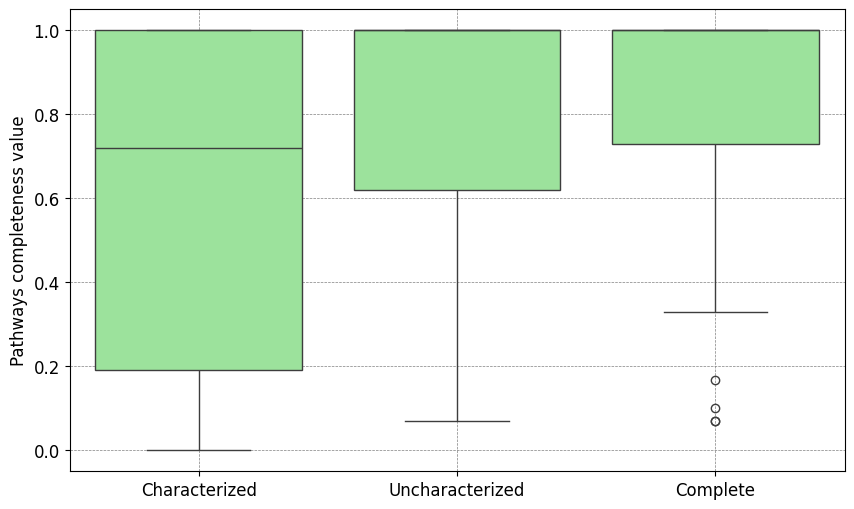

In [10]:
multi_df_nonzero = multi_df[(multi_df["Characterized"] > 0) | (multi_df["Uncharacterized"] > 0) | (multi_df["Complete"] > 0)]

# Generate a fully customized boxplot
keggabox(
    multi_df_nonzero,
    color="#90ee90",
    title="", title_fontsize = 12, title_weight = "normal",
    xlabel="",
    xticks_rotation = 0,
    ylabel="Pathways completeness value", ylabel_fontsize = 12, ylabel_weight = "normal",
    figsize=(10, 6),
    save_path="imgs/boxplot.png",
    save_format="png",
    save_dpi=600
)

Finally, let's combine all these `KEGGaNOG` plots into one!

/var/folders/kn/dm4gk8l50h9ccw7mv7pwj2dc0000gn/T/ipykernel_17349/697937501.py:8: UserWarning: The palette list has more values (22) than needed (16), which may not be intended.
  sns.barplot(data=pd_df_melted, x="Score", y="Pathway", hue="Score", palette=palette, dodge=False, legend=False, ax=ax1)
/Volumes/SAMSUNG_SSD/Documents/miniconda3/conda_envs/pathways/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.draw()
/var/folders/kn/dm4gk8l50h9ccw7mv7pwj2dc0000gn/T/ipykernel_17349/697937501.py:57: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("imgs/combined_plot.png", dpi=600, bbox_inches="tight")
/Volumes/SAMSUNG_SSD/Documents/miniconda3/conda_envs/pathways/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Poss

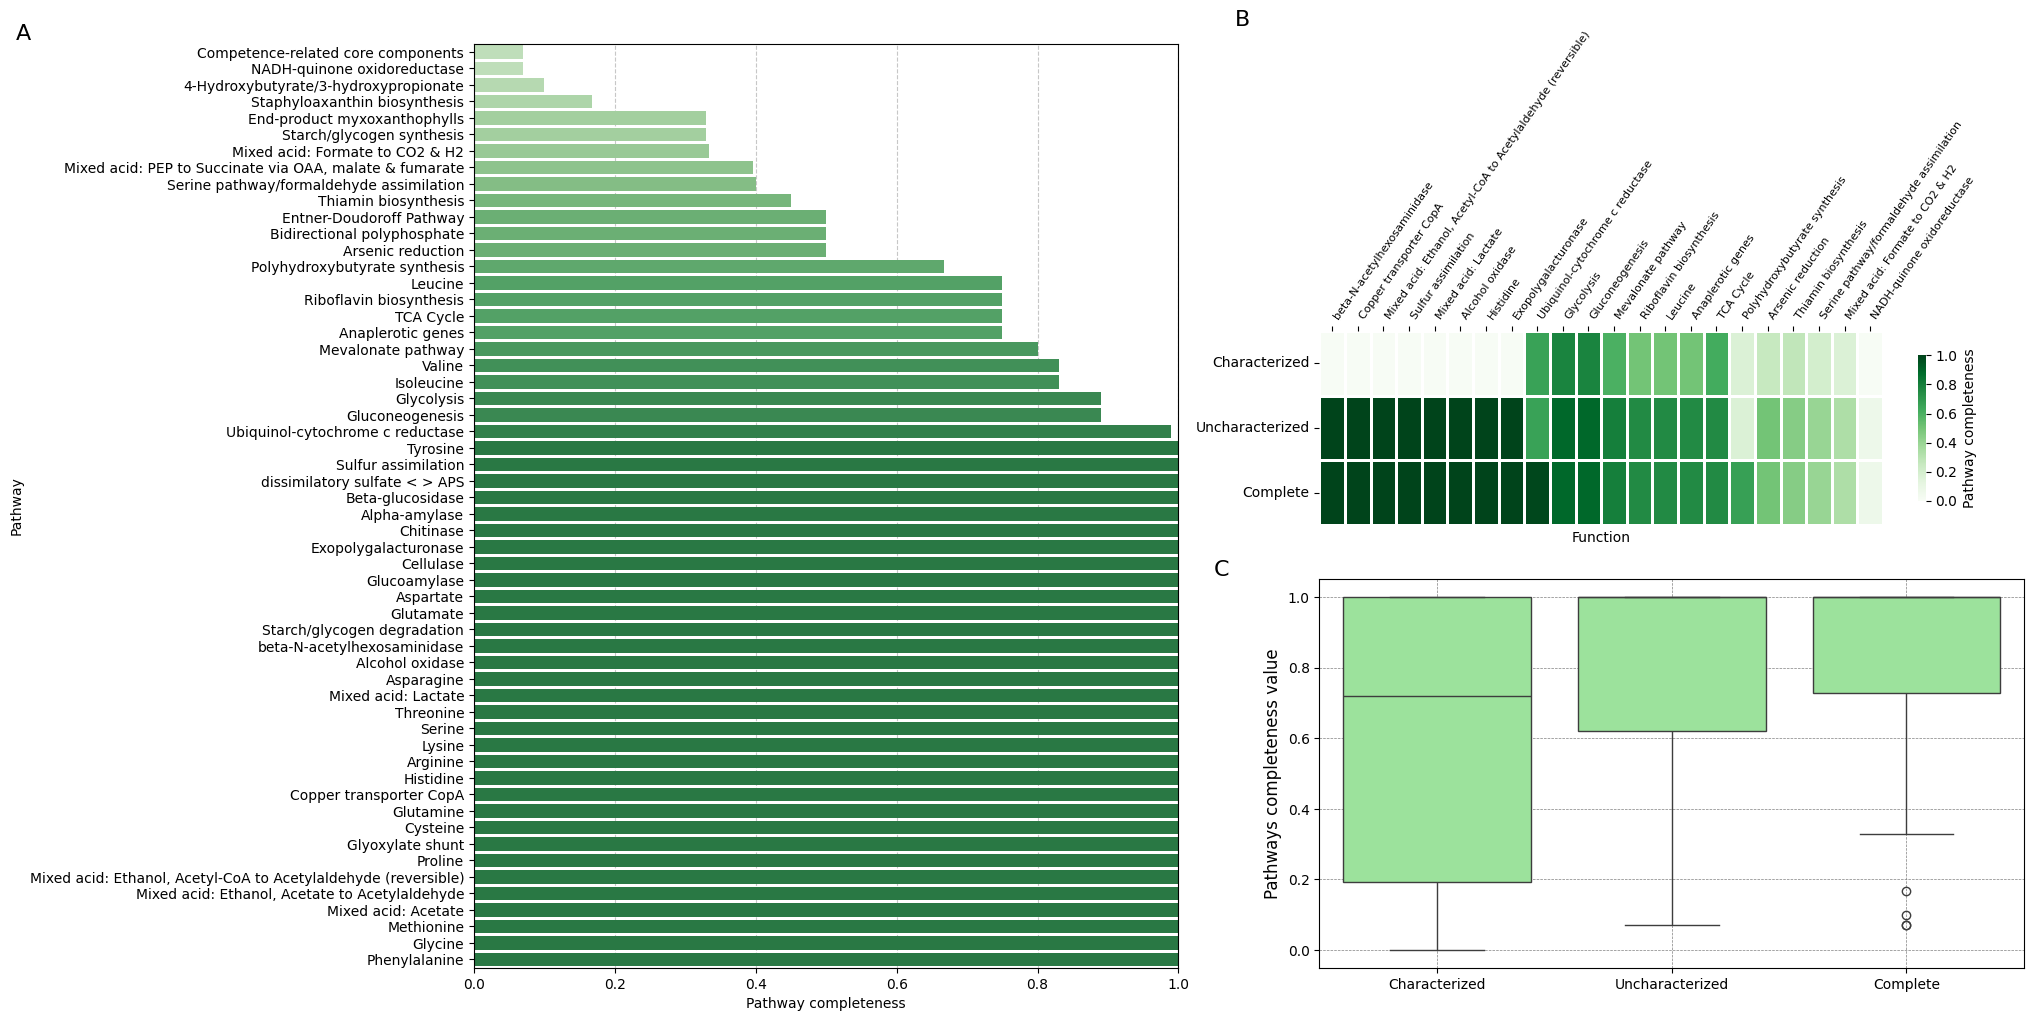

In [11]:
# Create a figure with a specific layout (1 row, 2 columns, right column split into 2)
fig = plt.figure(figsize=(20, 12), constrained_layout=True)
gs = GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1.2, 1, 2])  # Create grid layout with left side bigger

# Left section for Part 1: Barplot
ax1 = fig.add_subplot(gs[0:3, 0])  # Left side takes half of the figure
palette = sns.color_palette("Greens", n_colors=30)[8:]
sns.barplot(data=pd_df_melted, x="Score", y="Pathway", hue="Score", palette=palette, dodge=False, legend=False, ax=ax1)

ax1.set_xlabel("Pathway completeness")
ax1.set_ylabel("Pathway")
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7, zorder=0)
ax1.set_xlim(0, 1.0)
ax1.set_axisbelow(True)

# Right section: Split into two parts (Top for Part 2 and Bottom for Part 3)

# Part 2: Heatmap on the top of the right section
ax2 = fig.add_subplot(gs[1, 1])  # Top right
sns.heatmap(
    df_sorted.T,
    cmap="Greens",
    annot=False,
    linewidths=2,
    cbar=True,
    cbar_kws={"label": "Pathway completeness", "shrink": 0.75},
    ax=ax2
)
ax2.xaxis.set_ticks_position('top')
ax2.set_xlabel("Function")
ax2.set_ylabel("")
plt.xticks(rotation=55, ha='left', fontsize=8)
plt.yticks(rotation=0)

# Part 3: Boxplot on the bottom of the right section
ax3 = fig.add_subplot(gs[2, 1])  # Bottom right
sns.boxplot(data=multi_df_nonzero.iloc[:, 1:], color="#90ee90", showfliers=True, ax=ax3)

ax3.set_ylabel("Pathways completeness value", fontsize=12)
ax3.set_xticks(range(len(multi_df_nonzero.columns[1:])))
ax3.set_xticklabels(multi_df_nonzero.columns[1:], rotation=0)
ax3.grid(color="gray", linestyle="--", linewidth=0.5)

# Add labels 'A', 'B', and 'C' manually with adjusted x positions to force them to the left

# Label A for ax1 (left section) with adjusted x position
ax1.set_title('A', fontsize=16, loc='left', x=-0.65, pad=0)

# Label B for ax2 (top-right section) with adjusted x position
ax2.set_title('B', fontsize=16, loc='left', x=-0.15, pad=0)

# Label C for ax3 (bottom-right section) with adjusted x position
ax3.set_title('C', fontsize=16, loc='left', x=-0.15, pad=0)

# Save and show the plot
plt.savefig("imgs/combined_plot.png", dpi=600, bbox_inches="tight")
plt.show()

That's literally all!